In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
import torch.nn as nn
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# random add

In [2]:
data = pd.read_csv("C://dropout_MC//dropout_MC//_02_build//data//train_data.csv")
train_data, others_data = train_test_split(data, test_size=0.7, random_state=42)

In [10]:
# random add data
selected_data, _  = train_test_split(data, test_size=0.85, random_state=42)

In [16]:
train_data = pd.concat([train_data, selected_data]).reset_index()

In [17]:
train_X = train_data[['latitude', 'longitude']].values
train_y = train_data['temp'].values.reshape(-1, 1) 

# Convert to PyTorch Tensors
X_tensor = torch.tensor(train_X, dtype=torch.float32)
y_tensor = torch.tensor(train_y, dtype=torch.float32)

# Create a dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Batch size can be adjusted depending on your dataset size and memory
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)


In [18]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
# Create an instance of the model and optimizer
model = NN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss() 

In [20]:
best_val_loss = float('inf') 
save_path = 'C://dropout_MC//dropout_MC//_03_analyze//model//add_data_random_model.pth' 
epochs = 1000

for epoch in range(epochs):
    # --- train ---
    model.train() 
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- evaluation ---
    model.eval() 
    val_loss = 0.0
    with torch.no_grad(): 
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    if (epoch + 1) % 100 == 0:
        print(f'epoch[{epoch+1}/{epochs}], eval: {avg_val_loss:.4f}')

    # --- best model save ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)

print("training finished!")
print(f"best model was saved at {save_path}: eval loss: {best_val_loss:.4f})")

epoch[100/1000], eval: 17.0595
epoch[200/1000], eval: 24.5183
epoch[300/1000], eval: 7.3290
epoch[400/1000], eval: 6.1973
epoch[500/1000], eval: 29.0179
epoch[600/1000], eval: 6.5633
epoch[700/1000], eval: 9.1142
epoch[800/1000], eval: 22.5546
epoch[900/1000], eval: 16.1775
epoch[1000/1000], eval: 9.5715
training finished!
best model was saved at C://dropout_MC//dropout_MC//_03_analyze//model//add_data_random_model.pth: eval loss: 5.1962)


In [21]:
loaded_model = NN()
loaded_model.load_state_dict(torch.load(save_path))
loaded_model.eval()

NN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [22]:
test_data = pd.read_csv("C://dropout_MC//dropout_MC//_02_build//data//test_data.csv")
test_X = train_X = test_data[['latitude', 'longitude']].values
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
y_pred = loaded_model(test_X_tensor).detach().numpy()
test_data["pred"] = y_pred
test_data.to_csv("C://dropout_MC//dropout_MC//_03_analyze//result//add_data_random_model_pred.csv", index=False)

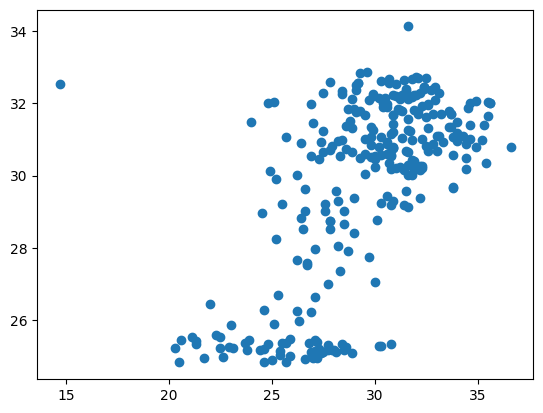

In [25]:
import matplotlib.pyplot as plt
plt.scatter(test_data["temp"], test_data["pred"])

In [33]:
from sklearn.metrics import root_mean_squared_error as rmse
rmse(test_data["temp"], test_data["pred"])

2.6792230187126673

# selected data

In [47]:
selected_data

,Unnamed: 0,var_latitude,var_longitude,var_value,matched_station_name,matched_station_latitude,matched_station_longitude,temp,distance
0,0,34.888889,135.131313,20.781235,三田,34.895000,135.211667,33.7,0.080586
1,1,37.333333,139.595960,20.383280,南郷,37.265000,139.536667,30.4,0.090472
2,2,32.000000,130.404040,19.466895,東市来,31.668333,130.328333,29.3,0.340197
3,3,36.444444,138.020202,18.300000,信州新町,36.548333,137.996667,33.9,0.106521
4,4,35.555556,133.818182,16.291111,倉吉,35.473333,133.838333,32.2,0.084656
...,...,...,...,...,...,...,...,...,...
95,95,37.555556,139.070707,2.996813,三条,37.640000,138.955000,32.4,0.143245
96,96,43.555556,144.060606,2.991202,阿寒湖畔,43.436667,144.083333,25.1,0.121042
97,97,38.666667,140.383838,2.981006,尾花沢,38.608333,140.411667,30.4,0.064631
98,98,39.111111,140.909091,2.973992,北上,39.288333,141.110000,28.9,0.267903


In [48]:
data = pd.read_csv("C://dropout_MC//dropout_MC//_02_build//data//train_data.csv")
train_data, others_data = train_test_split(data, test_size=0.7, random_state=42)

use_col = ["latitude", "longitude", "temp"]
train_data = train_data[use_col]

add_data = pd.read_csv("C://dropout_MC//dropout_MC//_03_analyze//result//match_result_df.csv")
selected_data = add_data.iloc[:100]
match_df_col = ["matched_station_latitude", "matched_station_longitude", "temp"]
selected_data = selected_data[match_df_col]
selected_data.columns = use_col
train_data = pd.concat([train_data, selected_data]).reset_index()

In [50]:
train_X = train_data[['latitude', 'longitude']].values
train_y = train_data['temp'].values.reshape(-1, 1) 

# Convert to PyTorch Tensors
X_tensor = torch.tensor(train_X, dtype=torch.float32)
y_tensor = torch.tensor(train_y, dtype=torch.float32)

# Create a dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Batch size can be adjusted depending on your dataset size and memory
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)

In [51]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.model(x)

In [52]:
# Create an instance of the model and optimizer
model = NN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss() 

In [53]:
best_val_loss = float('inf') 
save_path = 'C://dropout_MC//dropout_MC//_03_analyze//model//add_selected_data_model.pth' 
epochs = 1000

for epoch in range(epochs):
    # --- train ---
    model.train() 
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- evaluation ---
    model.eval() 
    val_loss = 0.0
    with torch.no_grad(): 
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    if (epoch + 1) % 100 == 0:
        print(f'epoch[{epoch+1}/{epochs}], eval: {avg_val_loss:.4f}')

    # --- best model save ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)

print("training finished!")
print(f"best model was saved at {save_path}: eval loss: {best_val_loss:.4f})")

epoch[100/1000], eval: 12.1350
epoch[200/1000], eval: 21.2094
epoch[300/1000], eval: 19.5911
epoch[400/1000], eval: 17.9573
epoch[500/1000], eval: 24.8324
epoch[600/1000], eval: 10.3867
epoch[700/1000], eval: 16.1438
epoch[800/1000], eval: 12.5572
epoch[900/1000], eval: 15.8393
epoch[1000/1000], eval: 8.6737
training finished!
best model was saved at C://dropout_MC//dropout_MC//_03_analyze//model//add_selected_data_model.pth: eval loss: 7.7250)


In [54]:
loaded_model = NN()
loaded_model.load_state_dict(torch.load(save_path))
loaded_model.eval()

NN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [59]:
test_data = pd.read_csv("C://dropout_MC//dropout_MC//_02_build//data//test_data.csv")
test_X = train_X = test_data[['latitude', 'longitude']].values
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
y_pred = loaded_model(test_X_tensor).detach().numpy()
test_data["pred"] = y_pred
test_data.to_csv("C://dropout_MC//dropout_MC//_03_analyze//result//add_selected_data_model_pred.csv", index=False)

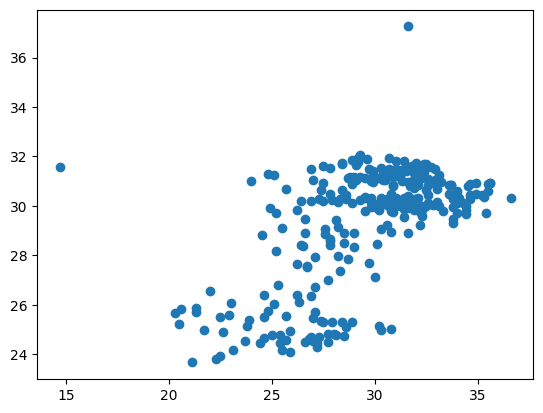

In [56]:
import matplotlib.pyplot as plt
plt.scatter(test_data["temp"], test_data["pred"])

In [57]:
from sklearn.metrics import root_mean_squared_error as rmse
rmse(test_data["temp"], test_data["pred"])

2.740976813251805